In [306]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add to utils.py: BER vs SNR, improve complex signal handling
- Add timing synchronization
- Add multipath effects to channel & equalizer
- Time offset
- Framing? Detect start of frame


Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add to utils.py: BER vs SNR, improve complex signal handling\n- Add timing synchronization\n- Add multipath effects to channel & equalizer\n- Time offset\n- Framing? Detect start of frame\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [307]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import importlib
import utils
importlib.reload(utils)
from utils import *


# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
SNR_DB = 10


/home/cdelong/sdr/sdr_notebooks/utils/visualization.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  if show: fig.show()


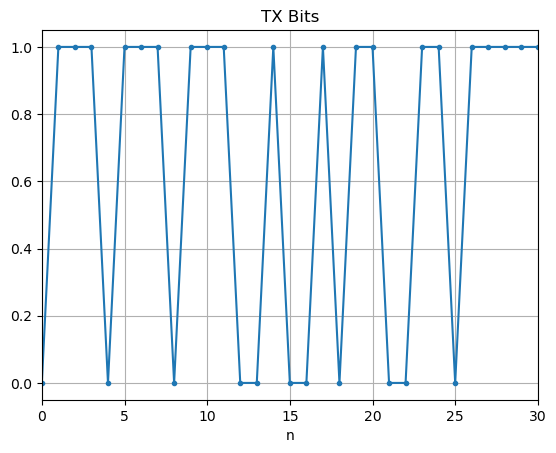

In [308]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

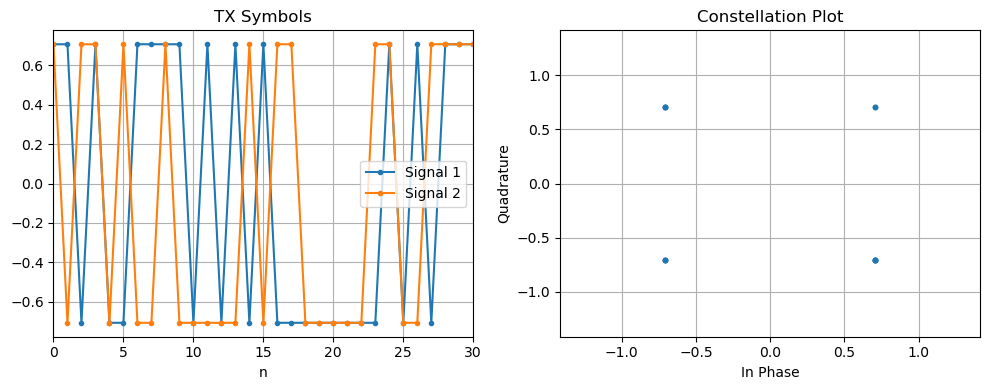

In [309]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
sym_tx = diff_encode_qpsk_symbols(modulate_qpsk(bits_tx))


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

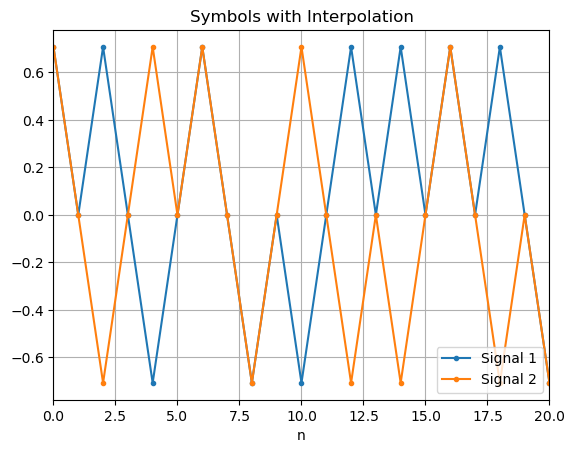

In [310]:
### Pulse filtering ###

# Interpolate by factor of SPS
sym_interp = np.zeros(N_SYMBOLS * SPS, dtype=np.complex128)
sym_interp[::SPS] = sym_tx

plot_signal(sym_interp.real, sym_interp.imag, title='Symbols with Interpolation', xlim=[0, 10*SPS])

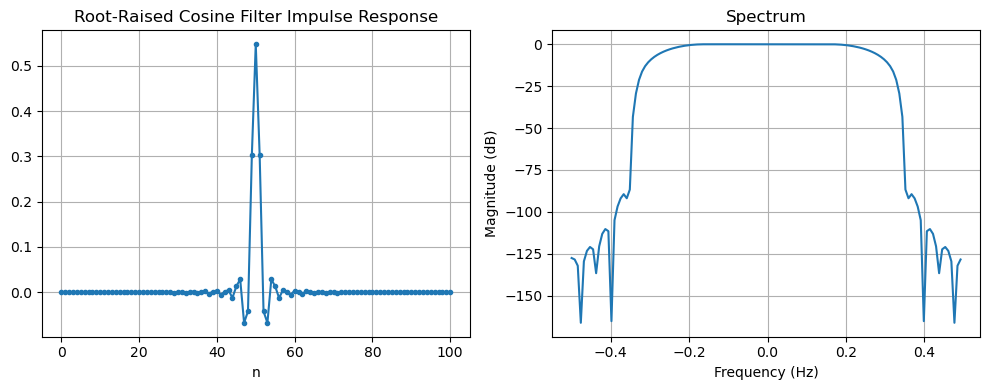

In [311]:
h_rrc = rrc_coef(Ts=SPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

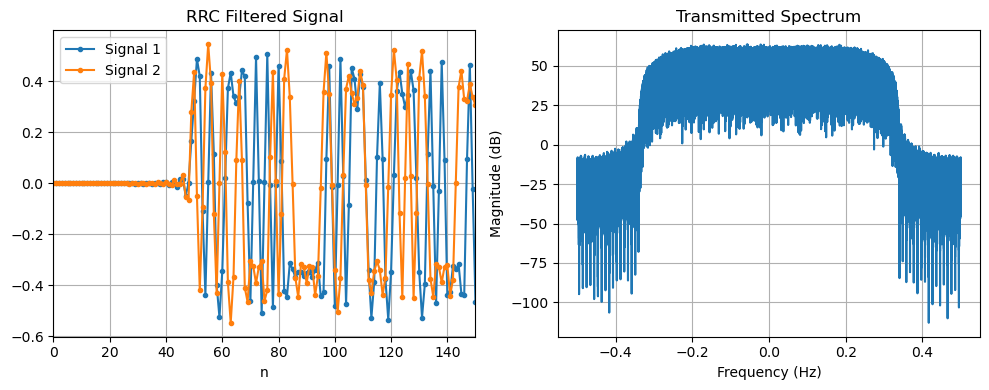

In [312]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_interp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

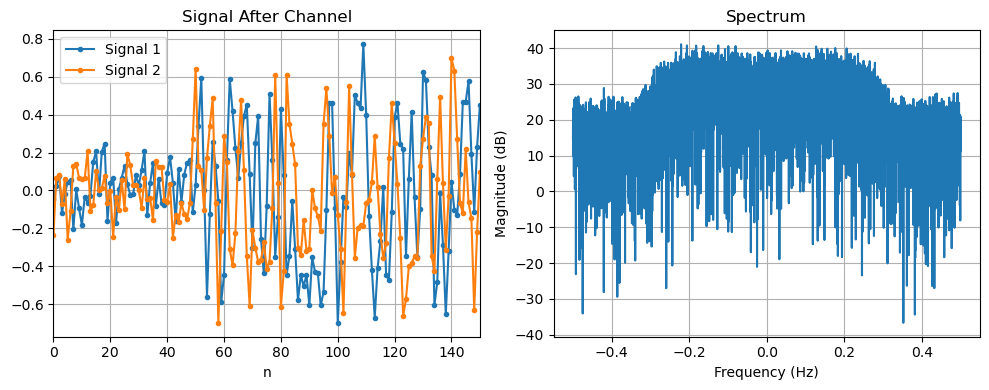

In [313]:
### Channel ###

n = np.arange(len(sig_tx))

# Apply CFO
abs_max_off = 0.01 * (2*np.pi)   # testing/realistic: 1-5%, aggressive: 10%
w_off = 2*abs_max_off*np.random.rand() - abs_max_off  # [radians/sample]
sig_tx = sig_tx * np.exp(1j*w_off*n)

# Apply CPO
p_off = 2*np.pi*np.random.rand()  # [radians]
sig_tx = sig_tx * np.exp(1j*p_off)

# Apply symbol timing offset
t_off = SPS*np.random.rand()


# AWGN
signal_power = np.mean(abs(sig_tx) ** 2)
noise_power = signal_power / (10**(SNR_DB / 10))
awgn = np.sqrt(noise_power / 2) * (np.random.normal(0, 1, len(sig_tx)) + 1j * np.random.normal(0, 1, len(sig_tx)))
sig_rx = sig_tx + awgn

# Visualize signal after channel
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()


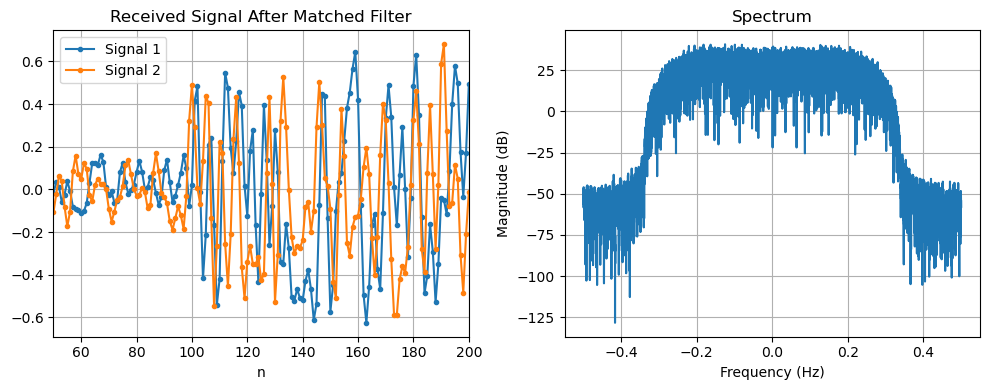

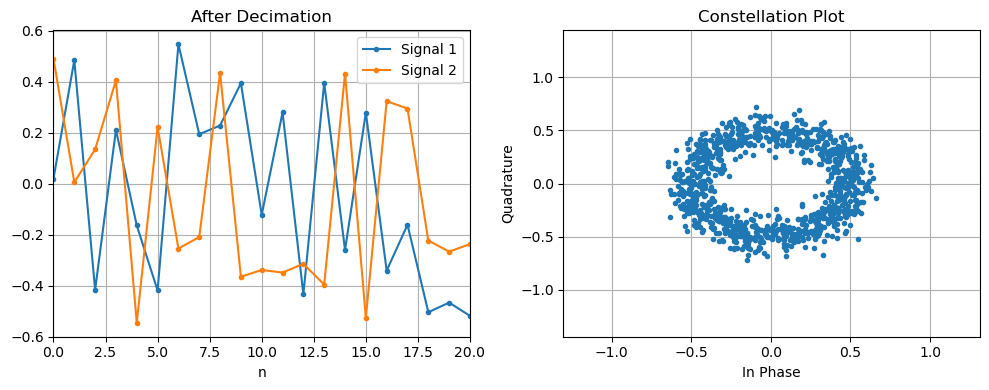

In [314]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()

# Remove extra shit from convolutions
sig_matched = sig_matched[100:-100]

# Decimate to 1 sps
sig_dec = np.empty(len(sig_matched) // SPS, dtype=np.complex128)
for i, samp in enumerate(sig_matched):
    if i % SPS == 0:
        sig_dec[i//SPS] = samp

# Plot decimated
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_dec.real, sig_dec.imag, title='After Decimation', xlim=[0, 20], ax=axs[0])
plot_constellation(sig_dec, n_samples=1000, ax=axs[1])
plt.tight_layout()
plt.show()

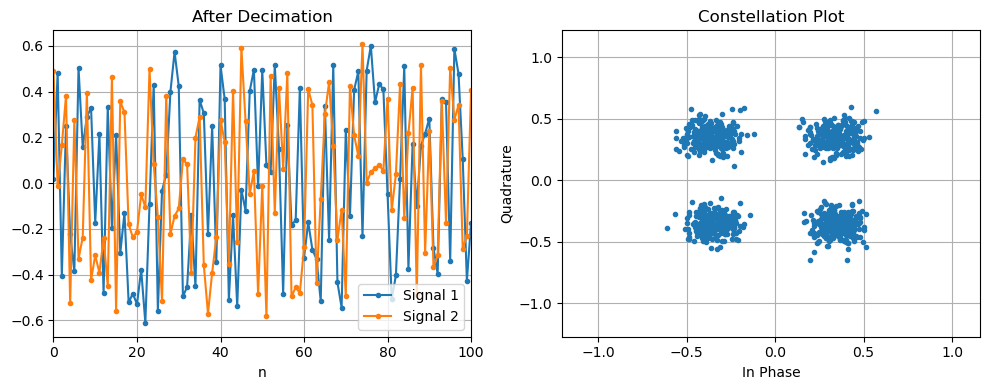

In [315]:
### Symbol Synchronization ###


### 2nd Order Costas Loop ###

# The loop is very slow (~6 seconds) when ran as pure python. Use JIT compilation 
# using numba to speed this up by over an order of magnitude

@njit
def costas_loop(symbols, K_p, K_i):
    sum_e = 0.0
    theta1 = 0.0
    sym_rot = np.empty(len(symbols), dtype=np.complex128)


    for i, s in enumerate(symbols):
        
        # Rotate signal by current VCO phase
        s_rot = s * np.exp(-1j * theta1)
        
        # Decision-directed error signal
        I = s_rot.real
        Q = s_rot.imag
        ref = np.sign(I) + 1j*np.sign(Q)
        e = np.angle(s_rot * np.conj(ref))  # Phase error

        # Update VCO input
        sum_e += K_i*e
        theta1 += K_p*e + sum_e

        sym_rot[i] = s_rot
    
    return sym_rot


K_p = 0.05
K_i = 0.001
sym_rot = costas_loop(sig_dec, K_p, K_i)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_rot.real, sym_rot.imag, title='After Decimation', xlim=[0, 100], ax=axs[0])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[1])
plt.tight_layout()
plt.show()

    

In [316]:
### Demodulation ###

# Make optimum decision for AWGN channel
bits_rx = demodulate_qpsk(diff_decode_qpsk_symbols(optimum_decider_qpsk(sym_rot)))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 4.1e-05


In [317]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))

[0 1 1 1 0 1 1 1 0 1 1 1 0 0 1]
[0 1 1 1 0 1 1 1 0 1 1 1 0 0 1]
41
